# Лінійна регресія: перенавчання та регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "Відповідь:".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом "bikes_rent.csv", в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знакомство с данными

# Завдання 1

Завантажте датасет за допомогою функції pandas.read_csv у змінну df. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [2]:
import pandas as pd

# Завантаження датасету
file_path = "/content/bikes_rent.csv"
df = pd.read_csv(file_path)

# Виведення перших 5 рядків
print(df.head())

# Перевірка на наявність пропусків
print(df.isnull().sum())

# Перевірка типів даних
print(df.dtypes)


   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  
season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp             0
hum

Для кожного дня прокату відомі такі ознаки:

* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 – немає свята, 1 – є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура у Цельсіях
* _atemp_: температура по відчуттям у Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є дійсні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної **cnt**.

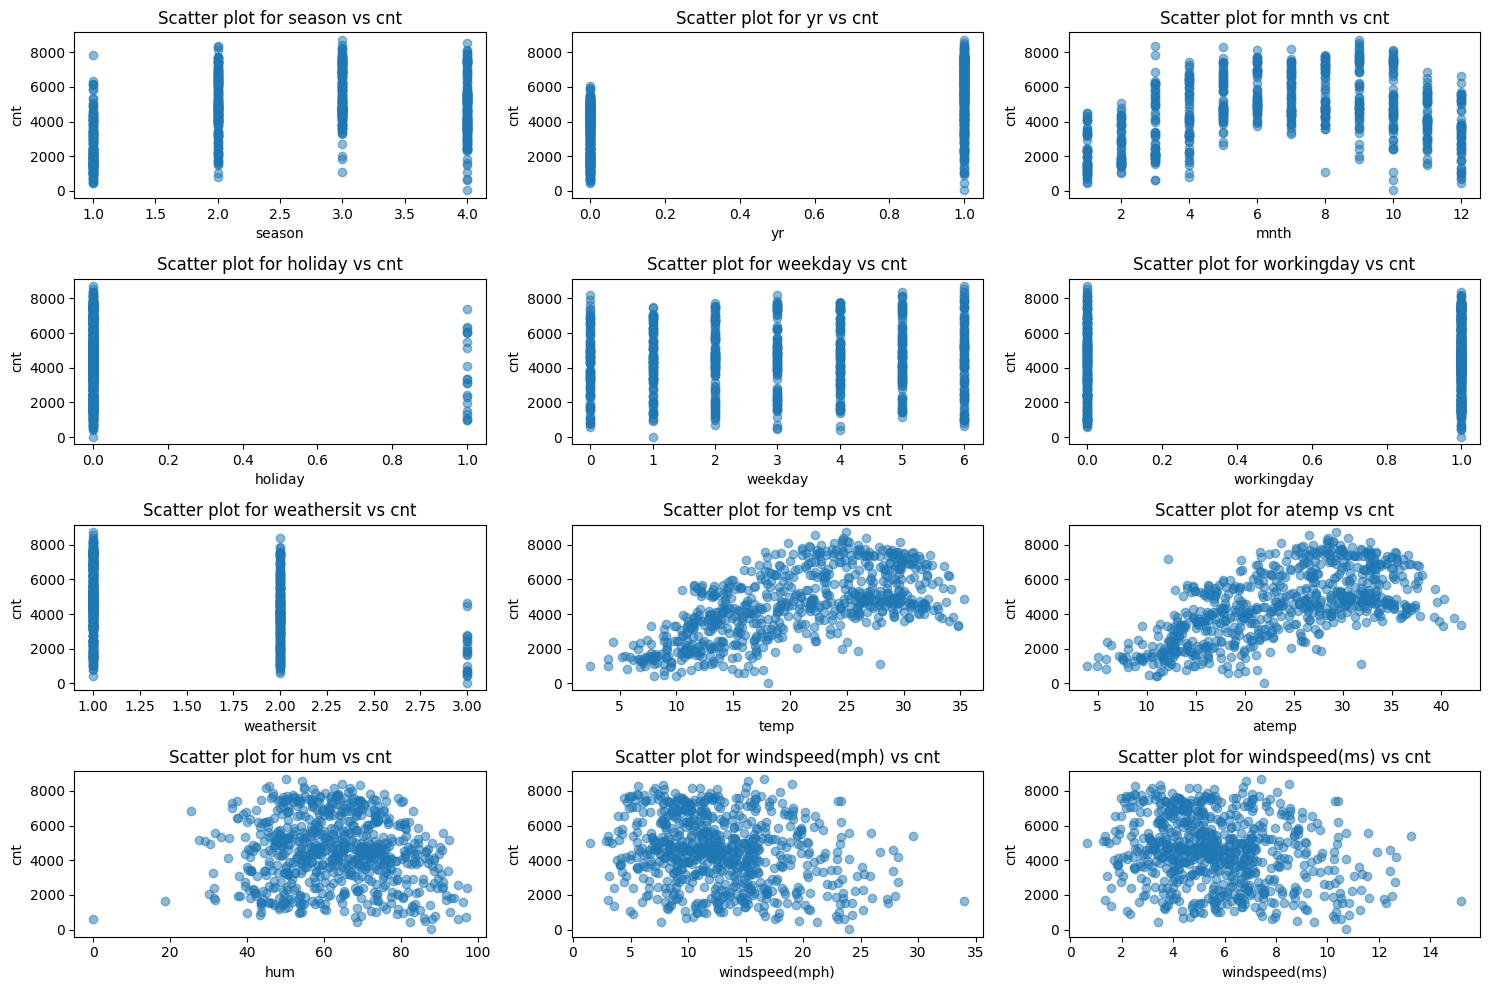

In [9]:
import matplotlib.pyplot as plt

# Список атрибутів, для яких будуть побудовані графіки
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Створюємо 4x3 сітку графіків (4 рядки, 3 стовпці)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

# Перебираємо атрибути і будуємо графіки
for i, attr in enumerate(attributes):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.scatter(df[attr], df['cnt'], alpha=0.5)
    ax.set_xlabel(attr)
    ax.set_ylabel('cnt')
    ax.set_title(f'Scatter plot for {attr} vs cnt')

# Вирівнюємо міжграфічні відстані та показуємо графіки
plt.tight_layout()
plt.show()


Питання:
1. Який характер залежності кількості прокатів від місяця?

Найбільша кількості прокатів в місяцях літа тобто
1. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно

season,yr,mnth,holiday,weekday,workingday,weathersit


# Завдання 2

Давайте суворо оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останнім за допомогою методу `corrwith`.

In [10]:
# Виберіть всі ознаки, крім останньої (зазвичай 'cnt')
features = df.iloc[:, :-1]

# Виберіть останню ознаку (зазвичай 'cnt')
target = df.iloc[:, -1]

# Порахуйте кореляцію між features і target
correlations = features.corrwith(target)

# Виведіть кореляції
print(correlations)


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

По графікам видно, деякі ознаки схожі один на одного. Тому давайте також порахуємо кореляції між дійсними ознаками.

# Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [11]:
# Виберіть відповідні ознаки з датасету
selected_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]

# Порахуйте попарні кореляції
correlation_matrix = selected_features.corr()

# Виведіть матрицю кореляцій
print(correlation_matrix)


                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


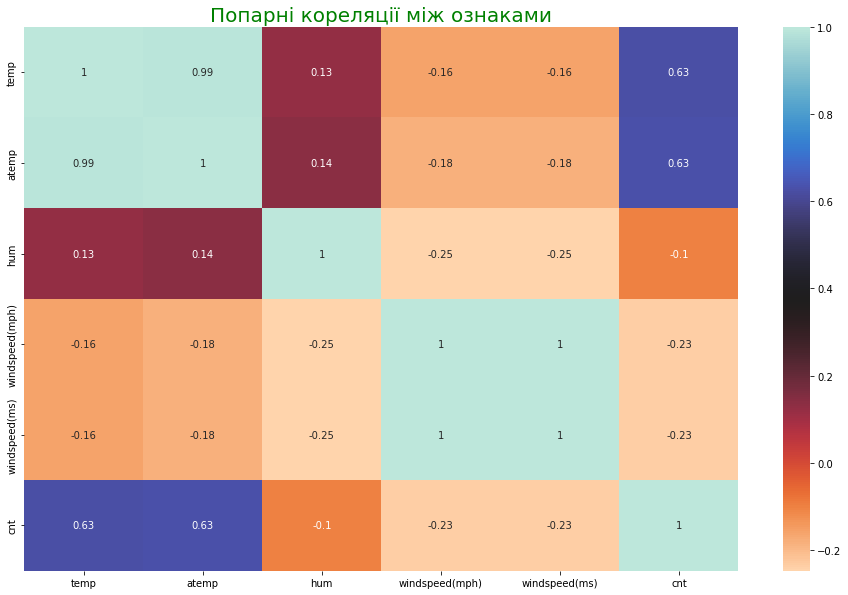

In [ ]:
plt.rcParams["figure.figsize"] = (16, 10)
sns.heatmap(df.iloc[:, 7:].corr(), annot=True, cmap='icefire_r')
plt.title('Попарні кореляції між ознаками', fontsize=20, color='g')
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

# Завдання 4

Виведіть середні ознаки

In [12]:
# Виведення середніх значень для всіх ознак
mean_values = df.mean()
print(mean_values)


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [ ]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [ ]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [ ]:
from sklearn.linear_model import LinearRegression

# Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.

In [14]:
from sklearn.linear_model import LinearRegression

# Створіть об'єкт лінійного регресора
model = LinearRegression()

# Розділіть дані на ознаки (X) та цільову змінну (y)
X = df.drop('cnt', axis=1)  # Всі ознаки крім 'cnt'
y = df['cnt']  # Цільова змінна 'cnt'

# Навчіть модель на всіх даних
model.fit(X, y)

# Виведіть ваги моделі
feature_weights = list(zip(df.columns[:-1], model.coef_))
for feature, weight in feature_weights:
    print(f'{feature}: {weight}')


season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


Ми бачимо, що ваги при лінійно-залежних ознаках по модулю значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколлінеарності_.

З парою (temp, atemp) трохи менш корелюючих змінних такого не сталося, проте на практиці завжди варто уважно стежити за коефіцієнтами за схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

# Завдання 6
Давайте спробуємо навчити лінійні моделі з L_1 і L_2-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за промовчанням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [15]:
from sklearn.linear_model import Lasso, Ridge

In [16]:
from sklearn.linear_model import Lasso

# Створіть об'єкт моделі Lasso
lasso_model = Lasso()

# Навчіть модель Lasso на всіх даних
lasso_model.fit(X, y)

# Виведіть ваги моделі Lasso
feature_weights_lasso = list(zip(df.columns[:-1], lasso_model.coef_))
for feature, weight in feature_weights_lasso:
    print(f'{feature}: {weight}')


season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

In [17]:
from sklearn.linear_model import Ridge

# Створіть об'єкт моделі Ridge
ridge_model = Ridge()

# Навчіть модель Ridge на всіх даних
ridge_model.fit(X, y)

# Виведіть ваги моделі Ridge
feature_weights_ridge = list(zip(df.columns[:-1], ridge_model.coef_))
for feature, weight in feature_weights_ridge:
    print(f'{feature}: {weight}')


season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги в список `coefs_ridge'` Конвертуйте отримані списки в `np.array`.

In [18]:
import numpy as np
from sklearn.linear_model import Lasso, Ridge

# Значення α (альфа) для регуляризації
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Створення списків для збереження ваг
coefs_lasso = []
coefs_ridge = []

# Навчання моделей Lasso і Ridge для різних значень α
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    ridge_model = Ridge(alpha=alpha)

    lasso_model.fit(X, y)
    ridge_model.fit(X, y)

    coefs_lasso.append(lasso_model.coef_)
    coefs_ridge.append(ridge_model.coef_)

# Конвертування списків в np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)


Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

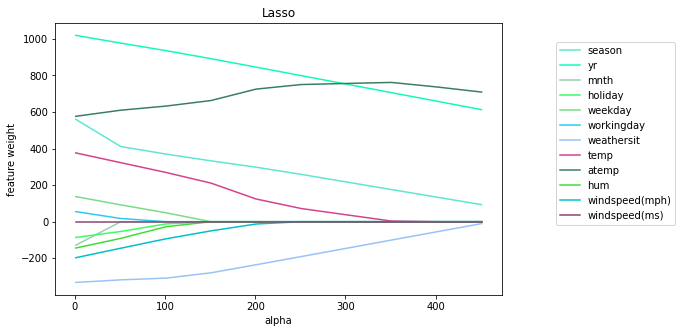

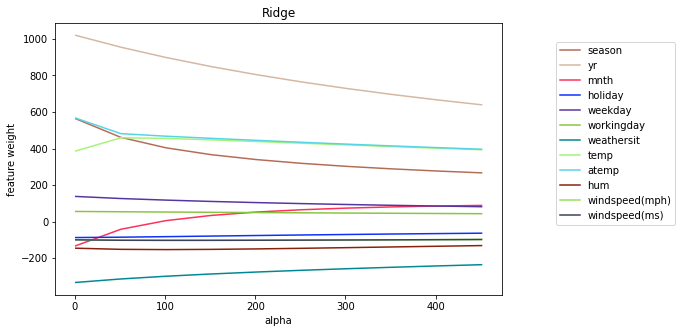

In [ ]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:

1.Lasso

2.Якщо значення параметра регуляризації α для моделі Lasso стане дуже великим, то ваги ознак в моделі Lasso будуть максимально обнулені або надзвичайно малі. Це стається через особливості L1-регуляризації, яка включає суму абсолютних значень ваг в об'єктивну функцію.

3.Так, Lasso (L1-регуляризація) виключає одну з ознак windspeed за будь-якого значення α > 0. Ridge (L2-регуляризація) не обнулює ваги для жодної ознаки, навіть при малих значеннях α. У Lasso ознака може бути виключена, якщо вага за неї стає меншою за 10^(-3).

4.Для відбору неінформативних ознак підходить регуляризатор L1 (Lasso), оскільки він має тенденцію обнулювати ваги для таких ознак.


### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що з зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не …анія на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиття вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ часто, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [19]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

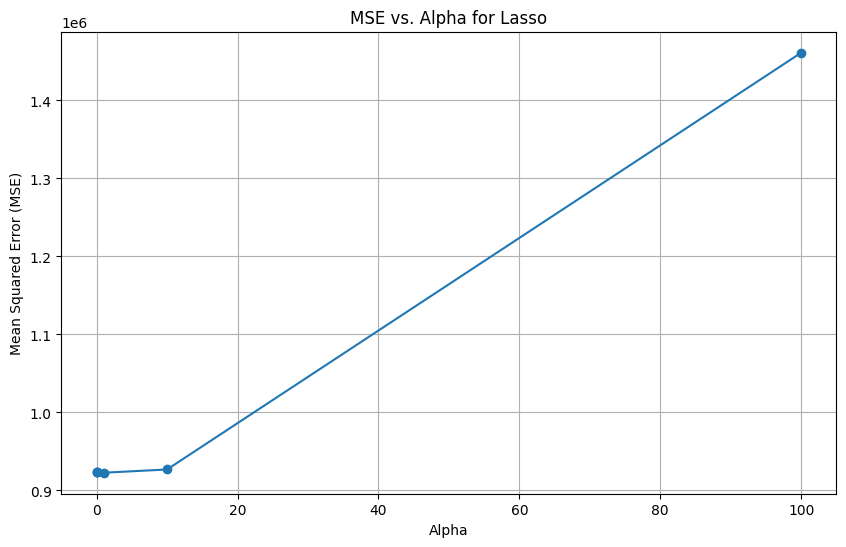

Optimal Alpha: 1.0
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


In [20]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# Створіть об'єкт регресора LassoCV зі списком значень alpha
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_cv = LassoCV(alphas=alphas, cv=3)

# Навчіть регресор на даних
lasso_cv.fit(X, y)

# Отримайте оптимальне значення alpha
optimal_alpha = lasso_cv.alpha_

# Отримайте середнє MSE для кожного alpha
mse_values = np.mean(lasso_cv.mse_path_, axis=1)

# Побудуйте графік MSE від alpha
plt.figure(figsize=(10, 6))
plt.plot(lasso_cv.alphas_, mse_values, marker='o', linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha for Lasso')
plt.grid(True)
plt.show()

# Виведіть оптимальне значення alpha
print(f'Optimal Alpha: {optimal_alpha}')

# Виведіть пари "ознака-коефіцієнт" для навчених ваг
feature_coefficients = list(zip(df.columns[:-1], lasso_cv.coef_))
for feature, coefficient in feature_coefficients:
    print(f'{feature}: {coefficient}')


Отже, ми вибрали певний параметр регулювання. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбиття (тобто по стовпцях).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.

Alpha values for min MSE on each fold:
Fold 1: 0.001
Fold 2: 100.0
Fold 3: 0.001


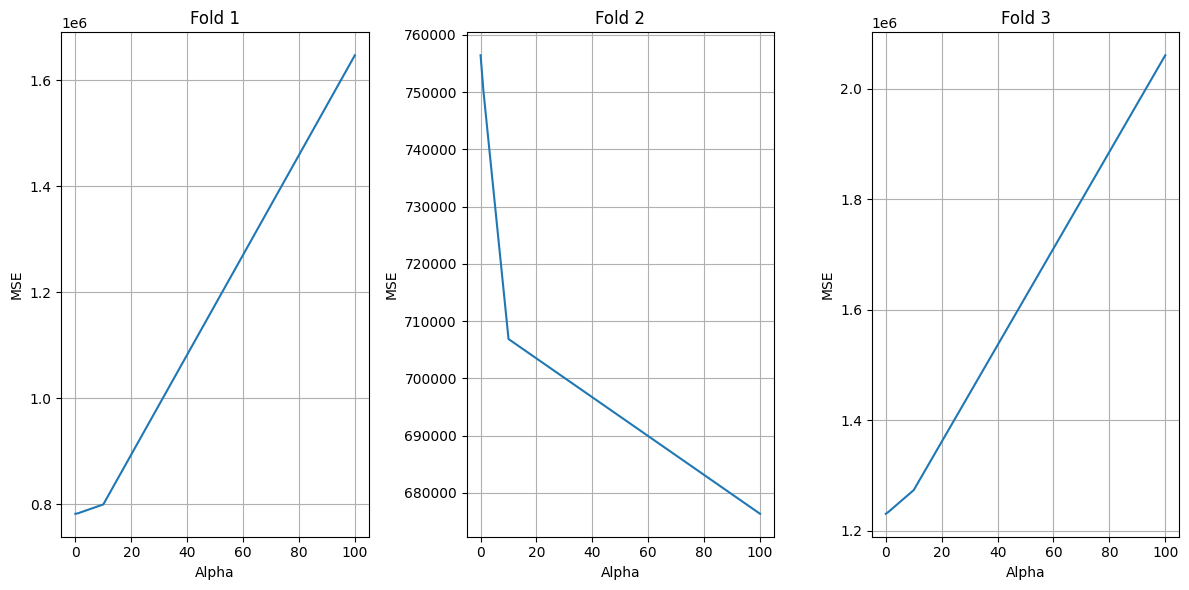

In [21]:
import matplotlib.pyplot as plt

# Отримайте значення alpha для кожного мінімуму MSE на кожному розбитті
alphas_for_min_mse = lasso_cv.alphas_[np.argmin(lasso_cv.mse_path_, axis=0)]

# Виведіть значення alpha для кожного розбиття
print("Alpha values for min MSE on each fold:")
for i, alpha in enumerate(alphas_for_min_mse):
    print(f"Fold {i+1}: {alpha}")

# Побудуйте графіки стовпців mse_path_
plt.figure(figsize=(12, 6))
for i in range(lasso_cv.mse_path_.shape[1]):
    plt.subplot(1, 3, i+1)
    plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_[:, i])
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.title(f'Fold {i+1}')
    plt.grid(True)

plt.tight_layout()
plt.show()


На кожному розбиття оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиття. Виходить, що ми налаштовуємось на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиття вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Відповідь:
1. temp
atemp
yr
season
2.На графіках залежностей cnt від цих ознак можна побачити зростаючу лінійну залежність. Логічно стверджувати, що чим вищі значення цих ознак, тим більше людей захочуть взяти велосипеди, особливо в контексті температури (temp і atemp), року (yr) і сезону (season). Більша температура, сезонність і рік можуть стимулювати більший попит на велосипеди.

In [ ]:
#Додайте код, якщо потрібно

#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

Відповідь:
1. weathersit
windspeed(mph)
workingday
2. Логічно стверджувати, що погана погода (weathersit), висока швидкість вітру (windspeed(mph)) і робочий день (workingday) можуть впливати на зменшення бажання людей взяти велосипеди, що відображається в негативних коефіцієнтах цих ознак.

#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

Відповідь:

1.Модель виключила ознаки з коефіцієнтами, близькими до нуля (<1e-3), ймовірно, через їхню слабу кореляцію з цільовою змінною cnt та можливу кореляцію з іншими ознаками. Модель намагається зберегти лише найважливіші та найінформативніші ознаки для прогнозування.

2.
З коефіцієнтами, близькими до нуля, можна припускати, що ці ознаки мають обмежений вплив на попит на велосипеди, або їх вплив є слабким і несуттєвим для моделі.

In [22]:
# Отримайте індекси ознак з коефіцієнтами, близькими до нуля
zero_coef_indices = np.abs(lasso_cv.coef_) < 1e-3

# Отримайте назви ознак з коефіцієнтами, близькими до нуля
zero_coef_features = df.columns[:-1][zero_coef_indices]

# Виведіть назви цих ознак
print("Features with coefficients close to zero:")
for feature in zero_coef_features:
    print(feature)


Features with coefficients close to zero:
windspeed(ms)


### Висновок
напишіть висновок
В результаті аналізу за допомогою Lasso-регресії було виявлено, що деякі ознаки мають важливий вплив на попит на велосипеди, в той час як інші мають обмежений або слабкий вплив.

Ознаки, які мають сильний позитивний вплив на попит на велосипеди, включають температуру, почуття температури, рік та сезон. Величина цих ознак позитивно корелює з кількістю прокатів, що логічно, оскільки більш тепла погода та сезонність можуть сприяти більшому попиту на велосипеди.

З іншого боку, ознаки, такі як погодні умови, швидкість вітру та робочий день, мають негативний вплив на попит на велосипеди. Ці ознаки можуть відлякувати покупців та призводити до зменшення кількості прокатів в такі дні або у погодні умови.

Модель також виключила деякі ознаки, які мають обмежений вплив на попит на велосипеди, або вони можуть бути корельовані з іншими ознаками, що вже включені в модель.